In [2]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
sns.set_style("dark")
sns.set_context("talk")
sns.set(rc = {'figure.figsize':(20,10)}, font_scale=1.5)

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas_datareader.data import DataReader
import datetime as dt

# libraries for pipeline|
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA

# Gridsearch
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score

#metrics
import sklearn.metrics as metrics

# Models to try
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

# custom functions
from modules import functions

# Market Data Gathering

In [3]:
# Important dates
start = dt.datetime(2021,8,14)
end = dt.datetime(2022,8,14)


In [4]:
# import data
nflx = DataReader("NFLX",  "yahoo", start, end)
gspc = DataReader("^GSPC", "yahoo", start, end)

In [5]:
# # concatenate stock and market data
features = functions.concatRename(nflx, 'nflx_', pd.DataFrame(gspc['Adj Close']), 'gspc_')

# Set-up time series prediction

Pipelines does not support dropping rows in the target data, so we must pre-process here. We take the features from the previous n days and use them to predict 

In [6]:
# target variable name
nflx_target = 'nflx_Adj Close'

# we do not drop the target variable, as we'll be shifting it
X = features
y = features[nflx_target]

In [7]:
# shift features and drop nans
rolling = 1
X_shifted = functions.shiftTime(X, rolling)

# find diff and drop nans
diff_delta = 1
X_diff = functions.trendDiff(X_shifted[[nflx_target]],diff_delta)

# put together
X_shifted = functions.concatRename(X_shifted, '', X_diff, 'diff_')
X_shifted.dropna(how='all', inplace=True)

# drop rolling rows from y
y_shifted = y.iloc[rolling:]

In [8]:
# take the last % for validation
test_size = 0.1

X_train, X_test = functions.testSplit(X_shifted, test_size)
y_train, y_test = functions.testSplit(y_shifted, test_size)

# Pipeline

In [9]:
# # specify feats for column transformer, those not included will be dropped
# num_feats = X_train.columns

# # only differenced columns
# num_feats = [feat for feat in X_train.columns if 'diff' in feat]

# Just important features
num_feats = ['nflx_Adj Close', 'nflx_Open', 'nflx_High', 'nflx_Low', 'nflx_Volume', 'gspc_Adj Close', 'diff_nflx_Adj Close']

In [10]:
# Feature Engineering Pipelines

num_transform = Pipeline([
    ('Imputer', KNNImputer()),
    ('scaling', StandardScaler()),
    # ('PCA', PCA(n_components=2))
    ])

In [11]:
feature_engineering = ColumnTransformer([
    ('num_transform', num_transform, num_feats),
    ], remainder='drop')

In [12]:
pipeline = Pipeline([
    ('feature_engineering', feature_engineering),
    ('regressor', LinearRegression()),
    ])

In [13]:
# calculate baseline score
model = pipeline.fit(X_train, y_train)

# calculate optimized score
print('# train pred')
y_train_pred = model.predict(X_train)
functions.regression_results(y_train, y_train_pred)

print('# test pred')
y_test_pred = model.predict(X_test)
functions.regression_results(y_test, y_test_pred)

# train pred
explained_variance:  0.993
mean_squared_log_error:  0.0018
r2:  0.993
MAE:  8.9953
MSE:  222.1962
RMSE:  14.9062
# test pred
explained_variance:  0.8982
mean_squared_log_error:  0.0012
r2:  0.8888
MAE:  5.8447
MSE:  53.7622
RMSE:  7.3323


<AxesSubplot:xlabel='Date'>

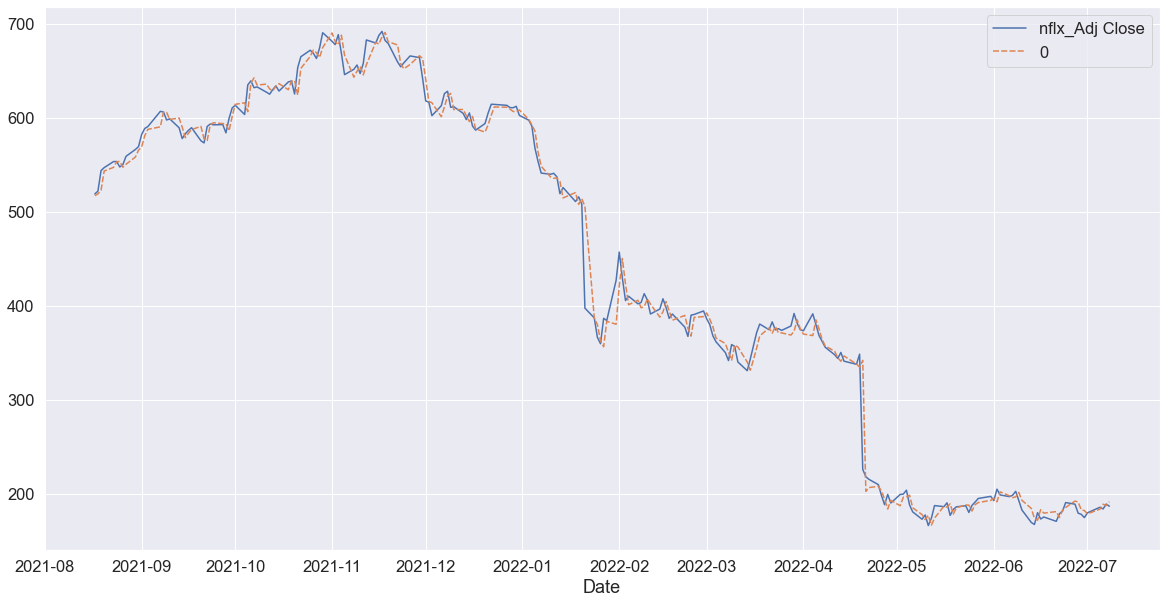

In [14]:
# plot training predictions
y_train_pred_df = pd.concat([y_train, pd.Series(y_train_pred, index=y_train.index)], axis=1)
sns.lineplot(data=y_train_pred_df)

In [15]:
# export
y_train_pred_df.to_csv('../data/results/baseline_pred.csv')

<AxesSubplot:xlabel='Date'>

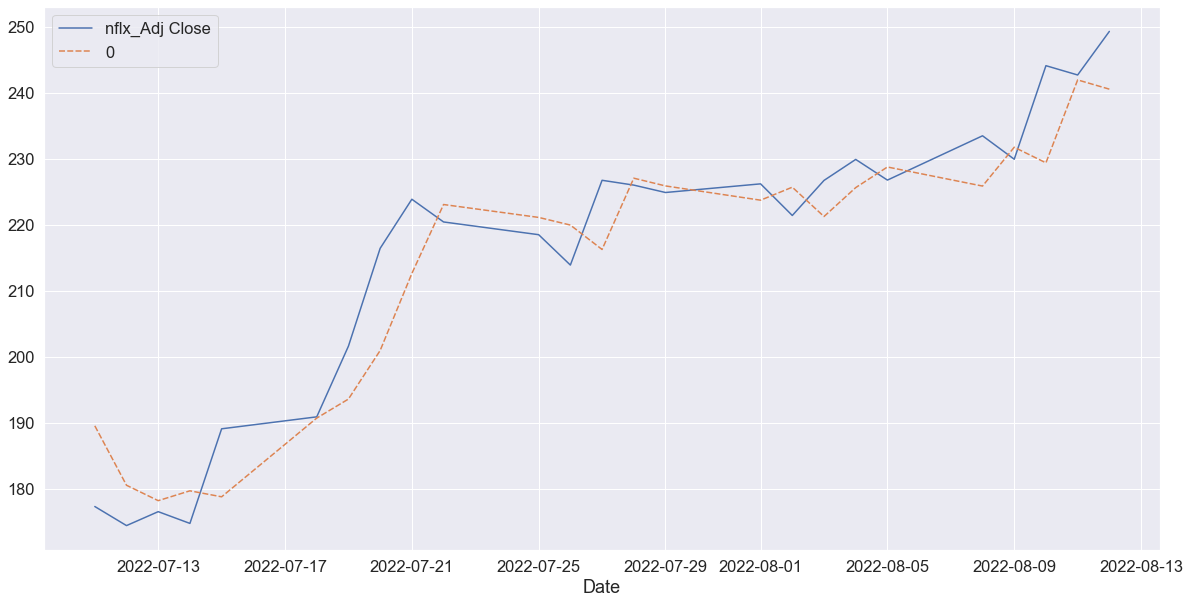

In [16]:
# plot predictions
y_test_pred_df = pd.concat([y_test, pd.Series(y_test_pred, index=y_test.index)], axis=1)
sns.lineplot(data=y_test_pred_df)

# Optimization

In [17]:
# model params
model_params = {
    'regressor': [
                LinearRegression(), 
                # MLPRegressor(solver='lbfgs'),
                KNeighborsRegressor(),
                RandomForestRegressor(n_estimators=10),
                SVR(gamma='auto'),
                xgb.XGBRegressor(),
                ]
}

In [18]:
# XGBoost params
xgb_params = {
    'regressor': [xgb.XGBRegressor()],
    # 'feature_engineering__num_transform_scaling': [MinMaxScaler(), StandardScaler()],
    'regressor__booster': ['gblinear'],
    'regressor__lambda': [0, 0.5, 1],
    'regressor__alpha': [0, 0.5 , 1],
}

In [19]:
# make custome scorer
rmse_score = metrics.make_scorer(functions.rmse, greater_is_better=False)

In [20]:
# instantiate gridsearch and time series CV technique
gridsearch = GridSearchCV(estimator=pipeline, param_grid=xgb_params, cv=TimeSeriesSplit(n_splits=3), scoring=rmse_score)

In [21]:
# find best model
gridsearch.fit(X_train, y_train)
best_model = gridsearch.best_estimator_
best_score = gridsearch.best_score_

In [22]:
# calculate optimized score
print('# train pred')
y_train_pred = best_model.predict(X_train)
functions.regression_results(y_train, y_train_pred)

print('# test pred')
y_test_pred = best_model.predict(X_test)
functions.regression_results(y_test, y_test_pred)

# train pred
explained_variance:  0.9924
mean_squared_log_error:  0.0019
r2:  0.9924
MAE:  9.6445
MSE:  239.3245
RMSE:  15.4701
# test pred
explained_variance:  0.9034
mean_squared_log_error:  0.0012
r2:  0.8918
MAE:  5.5373
MSE:  52.299
RMSE:  7.2318


[Text(0.5, 1.0, 'Baseline XGBRegressor (linear) - 1 yr ')]

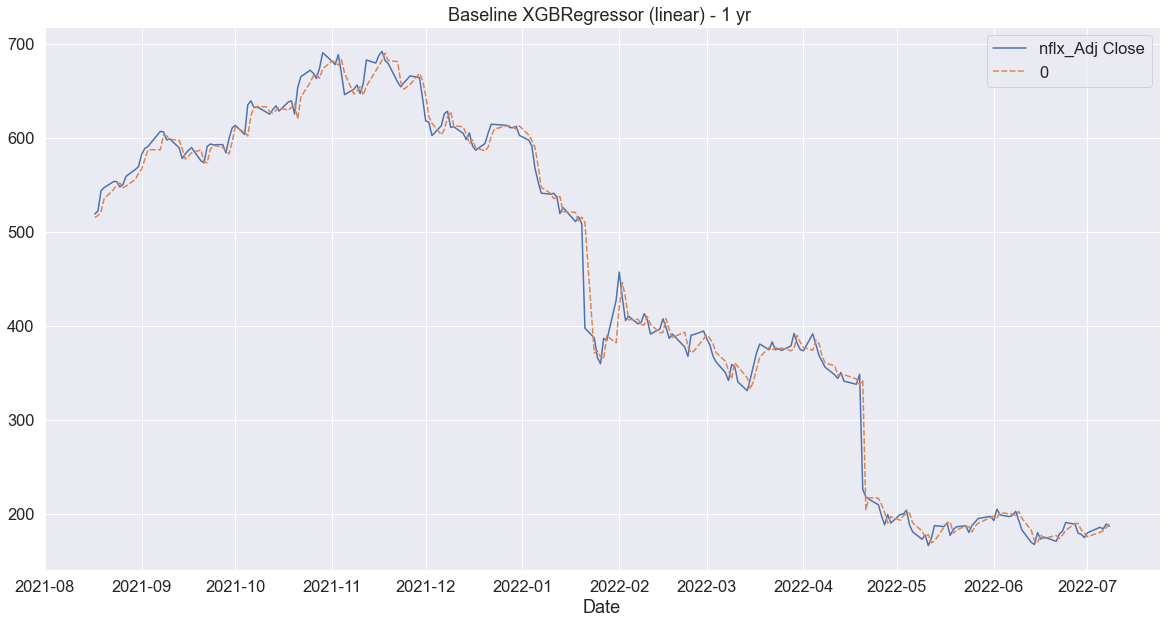

In [27]:
# plot training predictions
y_train_pred_df = pd.concat([y_train, pd.Series(y_train_pred, index=y_train.index)], axis=1)
sns.lineplot(data=y_train_pred_df).set(title='Baseline XGBRegressor (linear) - 1 yr ')

<AxesSubplot:xlabel='Date'>

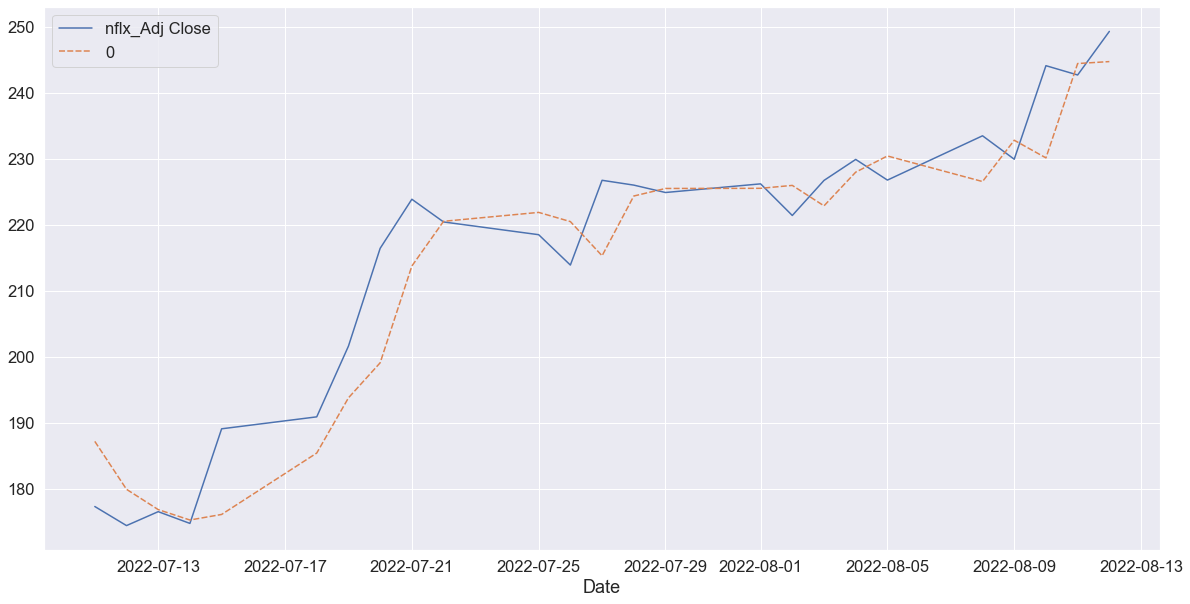

In [24]:
# plot predictions
y_test_pred_df = pd.concat([y_test, pd.Series(y_test_pred, index=y_test.index)], axis=1)
sns.lineplot(data=y_test_pred_df)